# Anomaly Detection

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('/Users/josuealemansanchez/Desktop/eco-tools')
from ecotools.pi_client import pi_client
pc = pi_client(root = 'readonly')
from data_helper import *
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

## Get Data

In [2]:
#search for point if needed
point = pc.search_by_point('*gbsf*elec*demand*kbtu*')
point

['GBSF_Electricity_Demand_kBtu']

### Set Data Parameters

In [3]:
start = '2016-01-01'
end = '*'
interval = '1h'
calculation = 'summary'

### Ensure only one point is passed

Grabbing WebIDs ...
WebID collection complete!
16:05:04: Sending API request... Chunk 1 of 1
16:05:06: Response recieved for 1 tags! (1.48)


Column                      |Percent NaN | Rows NaN/Total Rows
--------------------------------------------------------------
GBSF_Electricity_Demand_kBtu|  0.07 %    | 23/31668


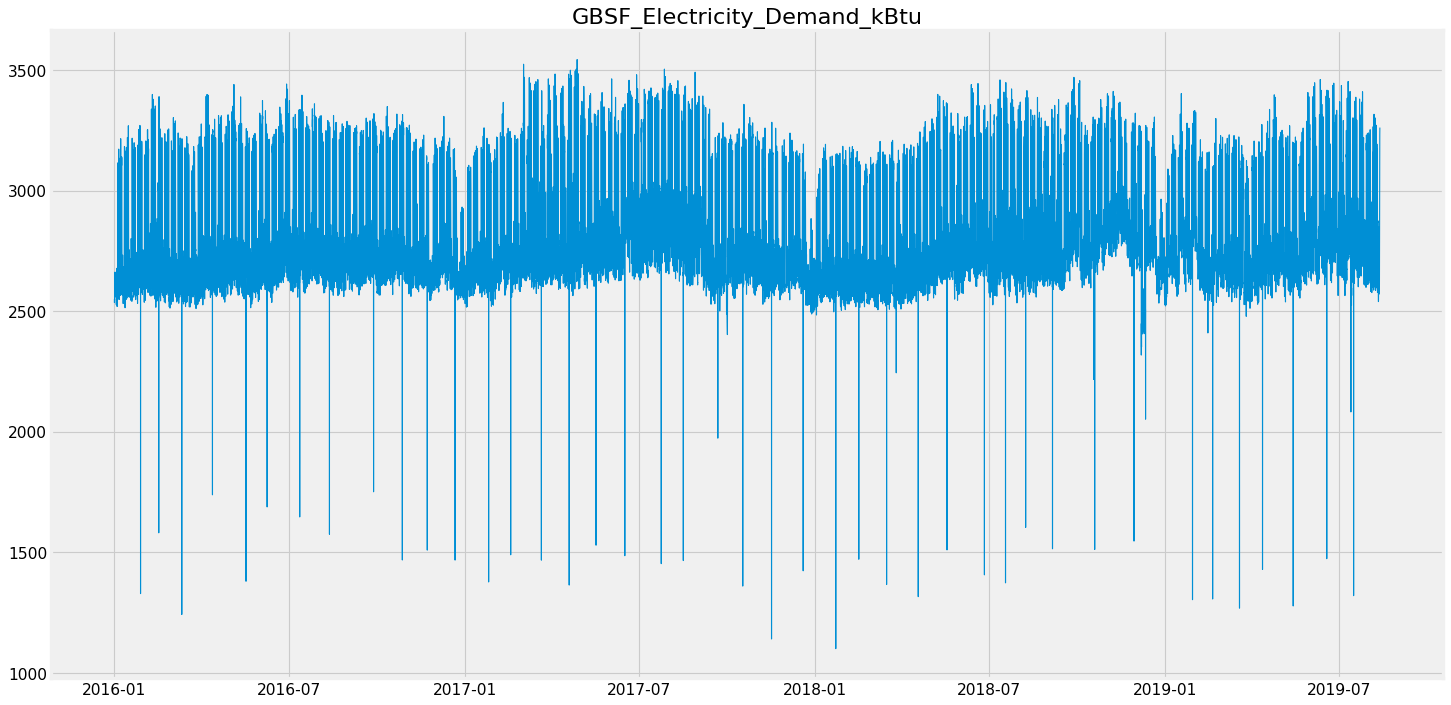

In [4]:
df = pc.get_stream_by_point(point, start = start, end = end, interval = interval, calculation = calculation)
print_report(df)

## Generate Model

In [5]:
kwargs = {
    #the point to be evaluated
    'point': point[0],
    
    #can be either 'LSTM' or 'Random Forest' or None
    'model_type': 'LSTM',
################################### Data Pre-processing ################################    
    #Determining the amount of data that will be used to train the model 0 < training_percent < 1.0
    'training_percent': 0.7,
    
    #determine if use wants the data to be cleaned 
    'clean_data': True,
    #TODO: Add upper and lower cutoff values
    #clean_type can be either 'value' (any points below the value passed will be cut out) or 'iqr'
    'clean_type': 'value',

    #if clean is 'value' then pass the value you want the cut to be
    # if you want IQR then determine the IQR to cut at
    #if values the threshold =  [lower_bound, upper_bound]
    'threshold': [2500, 3500],
    
    #Show plot with cutoff(s)
    'show_cutoff_plot': True,
    
    #show plot with training and testing data
    'show_cleaned_plot': True,
    
    #determine what method to use 'bfill' (back fill) or 'ffill' (foward fill) data 
    'method': 'bfill',
##############################################################    
    
    #determine if model should train on residuals or the normal data
    'train_on_residuals': True,
    
    'show_training_plot' : True,
    
    'show_results_plots' : True,
################################## Anomalies #######################
    'plot_anomalies': True

}

In [6]:
check_kwargs(kwargs)

'Good values!'

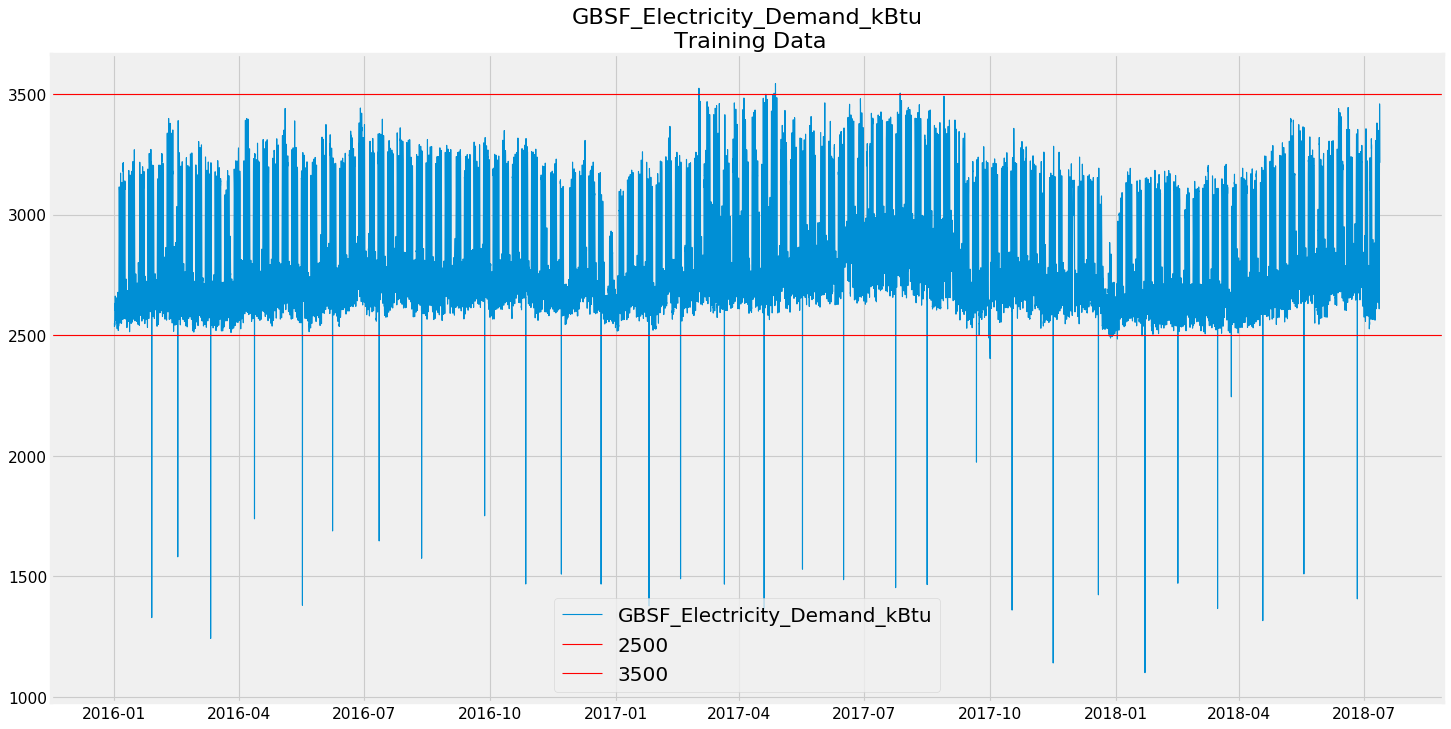

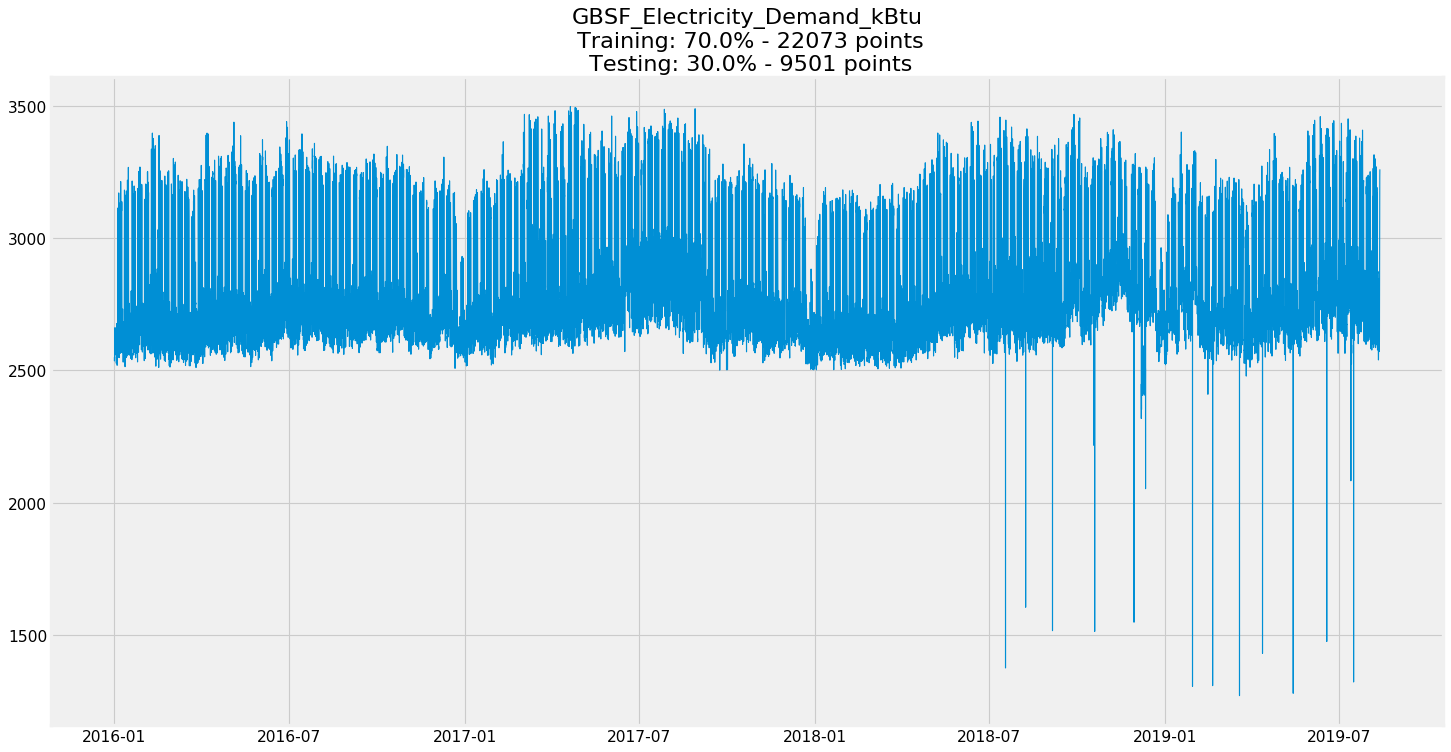

In [7]:
if kwargs['model_type'] is not None:
    df1 = split_and_clean(df, kwargs)

In [8]:
#plot_decomposed_data(df1[point[0]], kwargs)

Using TensorFlow backend.


Grabbing WebIDs ...
WebID collection complete!
16:05:10: Sending API request... Chunk 1 of 1
16:05:14: Response recieved for 3 tags! (3.9)
Removed: 0 rows
Train on 15518 samples, validate on 6652 samples
Epoch 1/4
15518/15518 [==============================] - 3s 211us/step - loss: 0.0281 - val_loss: 0.0016
Epoch 2/4
15518/15518 [==============================] - 2s 139us/step - loss: 9.0124e-04 - val_loss: 0.0020
Epoch 3/4
15518/15518 [==============================] - 2s 139us/step - loss: 6.9252e-04 - val_loss: 0.0014
Epoch 4/4
15518/15518 [==============================] - 2s 141us/step - loss: 6.2047e-04 - val_loss: 6.8034e-04


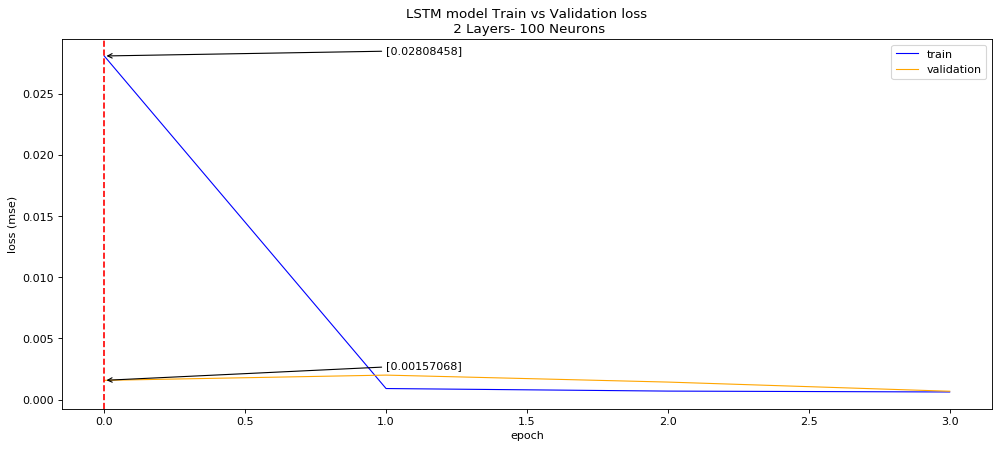

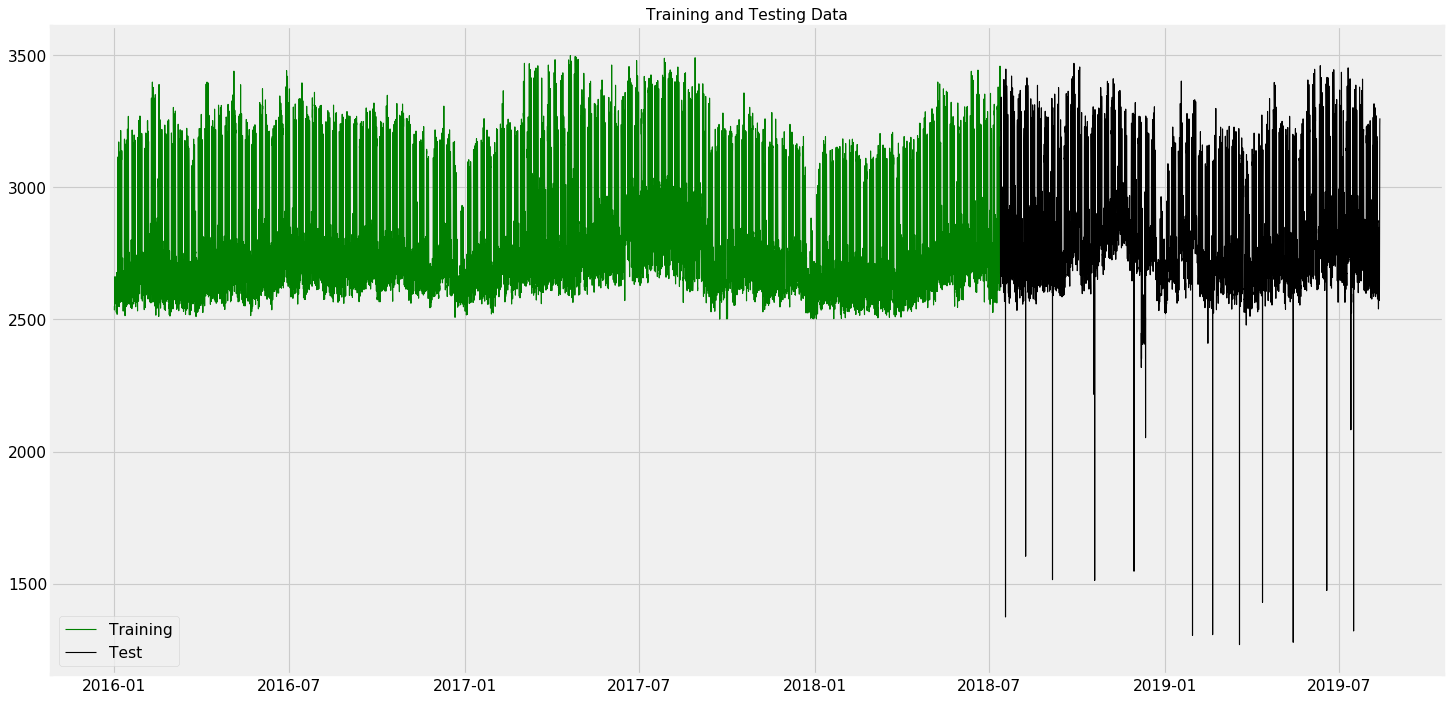

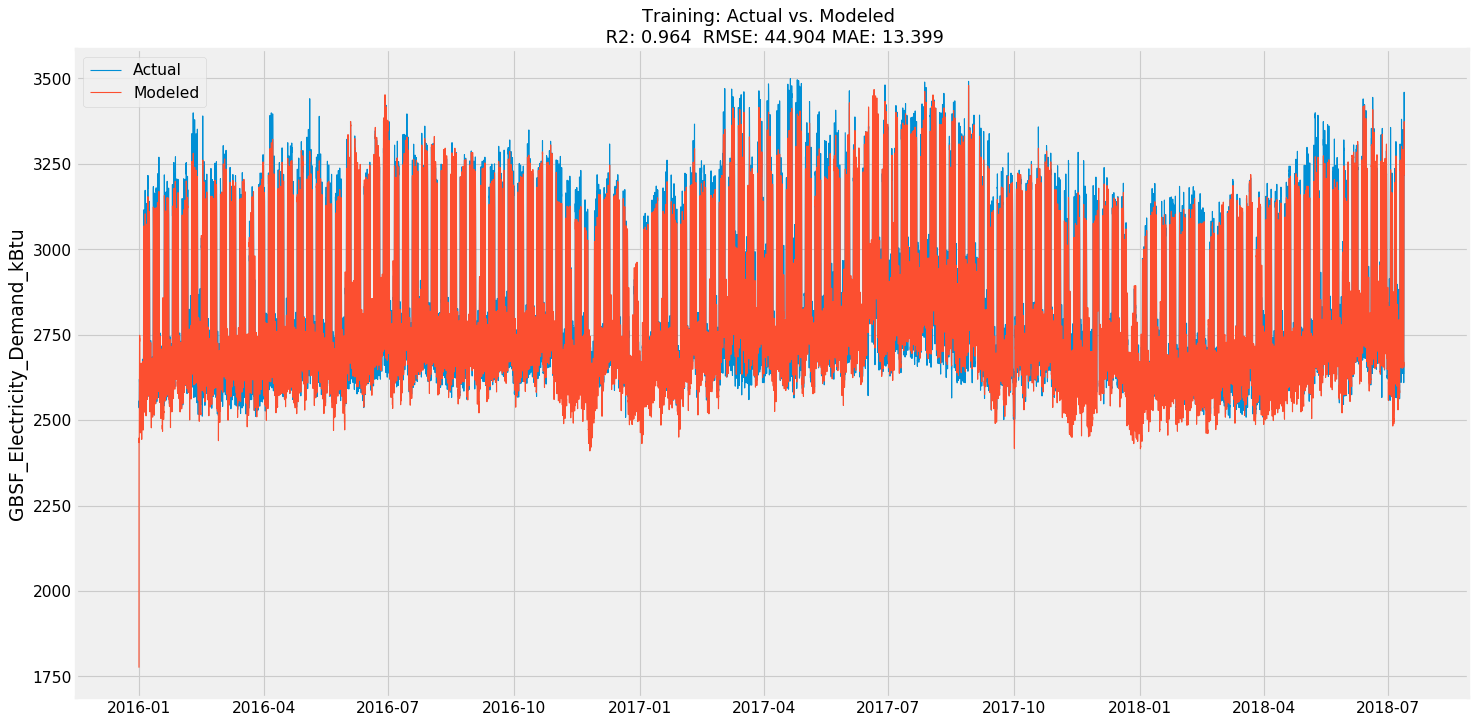

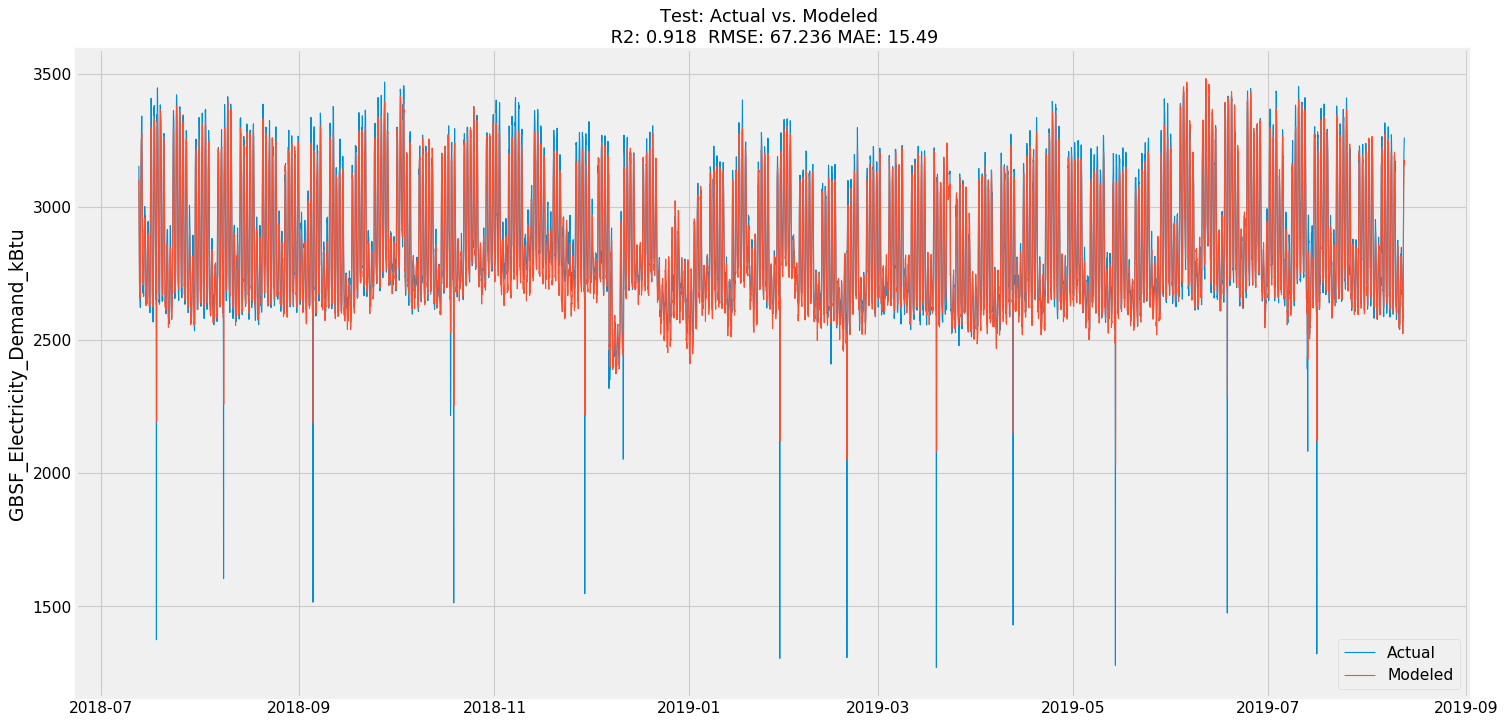

In [9]:
from model_generator import *
#model,X_train, X_test, y_train, y_test, scaler , train_idx, test_idx, data = create_model(df1, kwargs)
if kwargs['model_type'] is not None:
    train_df, test_df = create_model(df1, kwargs)
else:
    df3 = create_model(df, kwargs)
#     if kwargs['train_on_residuals']:
#         df3.Noise.plot(figsize = (20,10), linewidth = 2)
#     else:
#         df3.plot(figsize = (20,10), linewidth = 2)
    #test_df = df1.copy()

In [10]:
#test_df.eval('Result = Modeled - Actual')[['Result']].hist(bins = 100, figsize = (20,10))

In [11]:
#test_df.eval('Result2 = (Modeled - Actual)**2')[['Result2']].plot(figsize = (20,10))

In [12]:
#test_df.eval('Result2 = (Modeled - Actual)**2')[['Result2']].hist(bins = 100,figsize = (20,10))

In [13]:
#test_df.eval('Result = Modeled - Actual', inplace = True)
#test_df.to_csv('for_emma.csv')

In [14]:
#test_df.plot(figsize = (20,10), linewidth = 2)

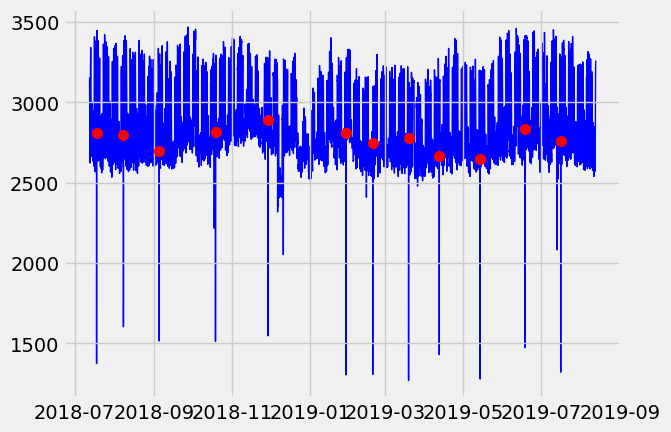

In [15]:
a_df = find_anomalies(test_df, kwargs)